### Video-Based Gaze Tracking tutorial (5/5)
This is a lecture of the Video-Based Gaze Tracking tutorial of the [Bridging the Technological Gap Summer Workshop](https://psychandneuro.duke.edu/opportunity/bridging-technological-gap-summer-workshop), July 31st – August 6th, 2022, German Primate Center, Göttingen, Germany.

More info at [https://github.com/erkil1452/gaze_workshop_public](https://github.com/erkil1452/gaze_workshop_public).

Made by Petr Kellnhofer, 2022.

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path('.').resolve().absolute().parent))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
import torch.nn as nn
import cv2
import nbimporter

# Automatically reload our library.
%reload_ext autoreload
%autoreload 1
from src import gaze_utils as gu
%aimport src

# Import solutions from our previous notebook(s).
from s01_capture import capture_frame, detect_face, crop_image
from s03_network import numpy_image_to_tensor, SimpleGazePredictor

DATA_PATH = Path('.').resolve().absolute().parent / 'data'
sample_data = gu.WorkshopDataset(DATA_PATH / 'gazecapture' / '00192')

## 5. Learning from a dataset

In this section, we will see how to build a tiny dataset of training data. We will then see how to fine tune a network pre-trained on a large dataset to improve robustness of our predictor.

### 5.1 Dataset collection

#### Option A: Use sample data (quick)

For initial test we can just use the sample data from the GazeCapture dataset. We can quickly populate our dataset with face images and gaze labels as below.

Collected 10 face images with labels.


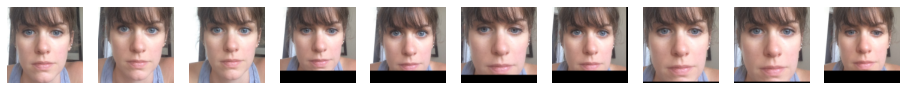

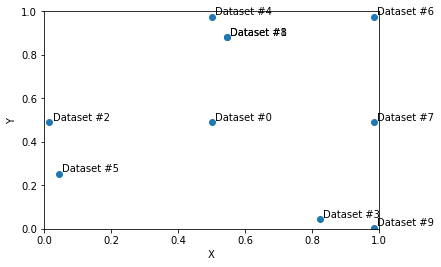

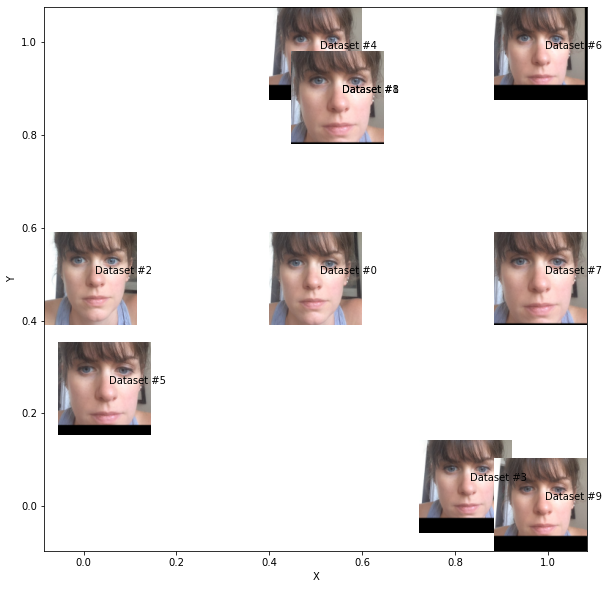

In [8]:
# Reset our dataset collection.
dataset = gu.OurDataset()

# Iterate over sample data.
for i in range(len(sample_data)):
    # 1. Get next image and label.
    frame = sample_data.get_image(i)
    label = sample_data.get_gaze(i)

    # 2. Detect the face.
    face_rect = detect_face(frame)

    if face_rect is not None:
        # 3. Crop the face with 1.2x margin.
        im_crop = crop_image(frame, face_rect, 1.2)
        label_tensor = torch.from_numpy(label).float()    

        # 4. To torch tensor with 127x127 resolution.
        im_tensor = numpy_image_to_tensor(im_crop, [127, 127])

        # 5. Add to dataset.
        dataset.add(im_tensor, label_tensor)

# Show all faces in our dataset.
print(f'Collected {len(dataset)} face images with labels.')
gu.show_images([im_tensor * 0.5 + 0.5 for im_tensor, label in dataset])   

# Visualize the dataset.
gu.plot_gaze([torch.stack(dataset._labels)], ['Dataset'])
gu.plot_gaze([torch.stack(dataset._labels)], ['Dataset'], [dataset._images], figsize=[16,10])

## Option B: Manually collect images using a webcam.

Step 1: Reset the dataset.

In [4]:
# Reset our dataset collection.
dataset = gu.OurDataset()

Step 2: Modify the first row to set gaze label. This is where you will be looking. We use [0,0] for bottom left of the screen, [1,1] for the top right and [1,0] for bottom right. 

Step 3: Look at that location and execute the cell. It should take a picture of you, detect your face and show it to you.

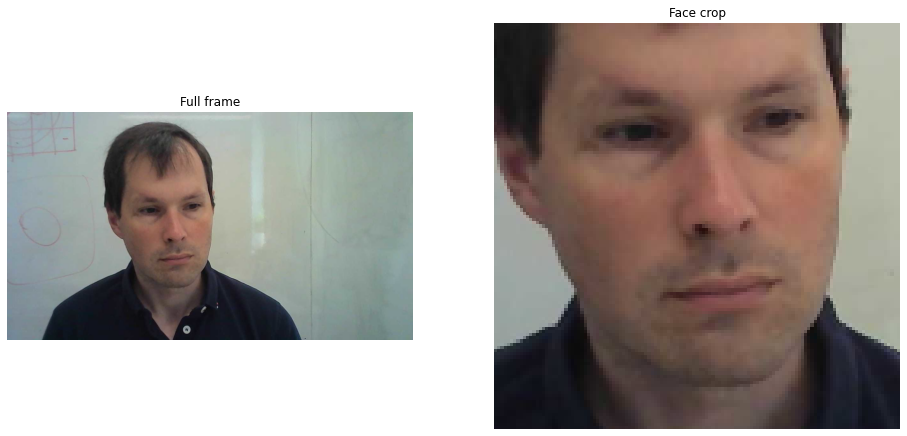

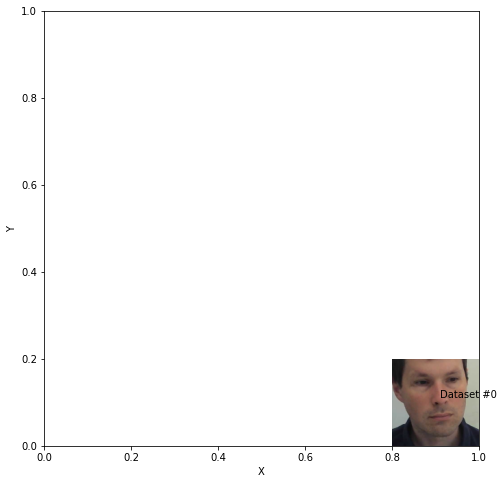

In [6]:
# START: Define your label here:
label = np.array([0.9, 0.1], dtype=np.float32) # MODIFY VALUES

# 1. Capture frame.
frame = capture_frame()

# 2. Detect the face.
face_rect = detect_face(frame)

if face_rect is not None:
    # 3. Crop the face with 1.2x margin.
    im_crop = crop_image(frame, face_rect, 1.2)

    # 4. To torch tensor with 127x127 resolution.
    im_tensor = numpy_image_to_tensor(im_crop, [127, 127])
    label_tensor = torch.from_numpy(label).float()    

    # Print
    im_tmp = frame.copy()
    cv2.rectangle(im_tmp, (face_rect.left(), face_rect.bottom()), (face_rect.right(), face_rect.top()), color=(255, 0, 0), thickness=4)
    gu.show_images([
        frame, 
        im_tensor * 0.5 + 0.5,
    ], ['Full frame', 'Face crop'])
    gu.plot_gaze([label[None]], ['Dataset'], [im_tensor[None]], figsize=[8,8])
else:
    print('Failed to detect frame!')
    im_tensor = None

Step 4: Validate the face crop above is correct, the face is well visible, the eyes are open. Also check that the gaze location visualized on the screen map matches you intentions. If either of this is not the case go back to step 2.

Step 5: If all is good, execute the next cell to add the image and label to our dataset and then return to step 2. Repeat as many times as you want (e.g. 10x).

We have so far collected 1 images.


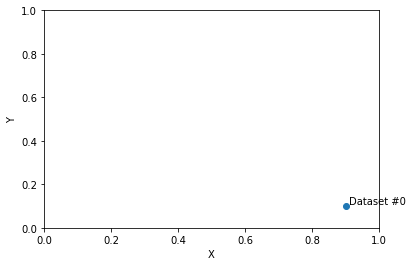

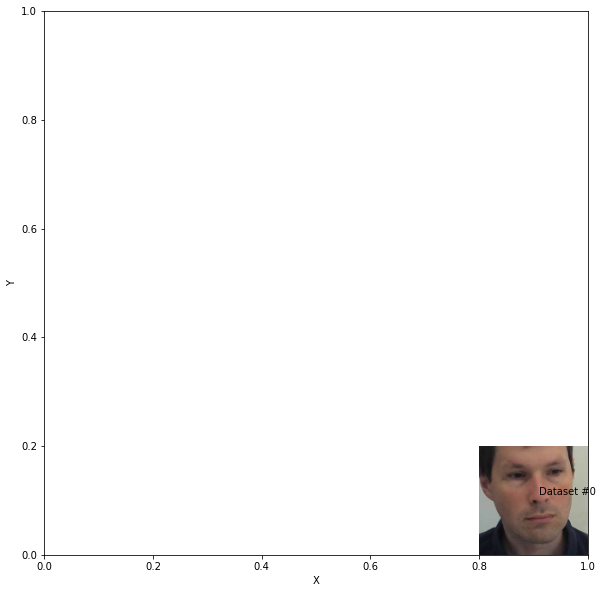

In [7]:
# Only if we have a valid image.
if im_tensor is not None:
    # Add to dataset.
    dataset.add(im_tensor, label_tensor)
    # Reset the image to avoid accidental multiple insertion.
    im_tensor = None

# Visualize the dataset collected so far.
print(f'We have so far collected {len(dataset)} images.')
gu.plot_gaze([torch.stack(dataset._labels)], ['Dataset'])
gu.plot_gaze([torch.stack(dataset._labels)], ['Dataset'], [dataset._images], figsize=[16,10])

### 5.2 Training with dataset

To train with dataset we iterate over its data in small batches. Batches are (usually random) subsets of the dataset that are small enough to fit on the GPU but large enough to represent the trends in the dataset. Pytorch provides a convenient wrapper for our dataset that generates the batches on the fly.

In [9]:
# DataLoader batches the samples together.
train_dl = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=False, num_workers=0)

# Print
print(f'Dataset length = {len(dataset)}')
print(f'Data loader length = {len(train_dl)}')
# print(f'Item #0 = {dataset[0]}')

Dataset length = 10
Data loader length = 1


Now we can train with our entire tiny dataset. Everything stays the same as with the only image but we add an extra inner loop to iterate over the data. Note that we only train for a very few steps here. Real training with real dataset might take hours or days.

Epoch 0: Loss = 0.367
Epoch 10: Loss = 0.354
Epoch 20: Loss = 0.183
Epoch 30: Loss = 0.116
Epoch 40: Loss = 0.115


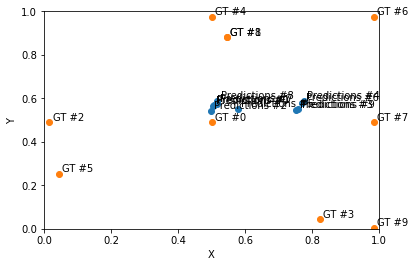

In [10]:
# Re-initialize the model and optimizer.
model = SimpleGazePredictor()
optim = torch.optim.Adam(lr=1e-3, params=model.parameters())
criterion = nn.MSELoss()

# Repeat 50 times.
for epoch in range(50):
    # Iterate over data here.
    for net_inputs, labels in train_dl:
        
        # Execute the model.
        net_outputs = model(net_inputs)

        # Compute loss.
        loss = criterion(net_outputs, labels)

        # Update the model parameters.
        optim.zero_grad()
        loss.backward()
        optim.step()

    if (epoch % 10 == 0):
        print(f'Epoch {epoch}: Loss = {loss.item():.3f}')

gu.plot_gaze([net_outputs, labels], ['Predictions', 'GT'])

Let us repeat the mirror image experiment now.

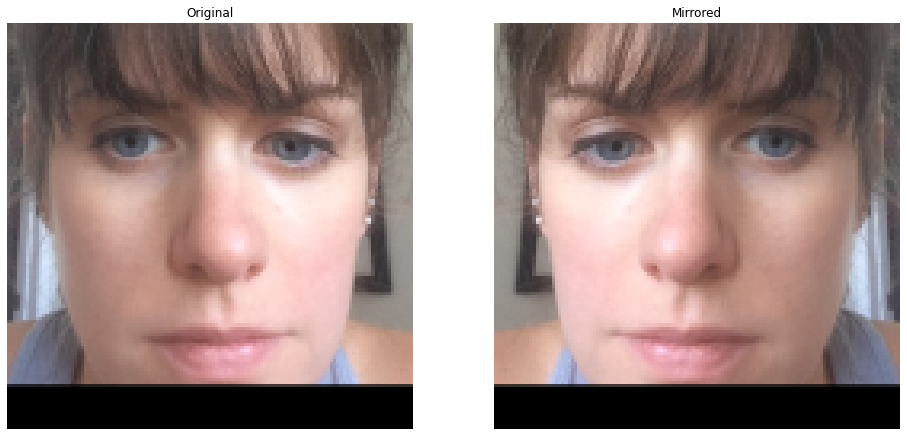

In [11]:
# Select the image that is furthest from the center.
net_input = net_inputs[5].unsqueeze(0)
gaze_label = labels[5]

# Flip the eye, show the difference => will be biased.
net_input_mirrored = torch.flip(net_input.detach(), [3]).requires_grad_(True) # B, C, H, W => invert the last dimension (width)
gu.show_images([
    net_input[0] * 0.5 + 0.5, 
    net_input_mirrored[0] * 0.5 + 0.5,
    ], ['Original', 'Mirrored'])

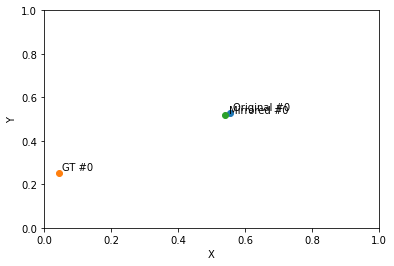

In [12]:
# Evaluate both images.
net_output = model(net_input)
net_output_mirrored = model(net_input_mirrored)

# Plot for comparison.
gu.plot_gaze([net_output, gaze_label, net_output_mirrored], ['Original', 'GT', 'Mirrored'])

Once again, the model cannot generalize and it cannot figure out what to do with the unseen mirrored face. We will need more data and training to fix that.

### 5.3 Fine-tune a pretrained model.

If we do not have enough data (or time) to train from scratch, we can instead fine-tune an already trained model. This is similar to calibration of a classical gaze tracker.

First, we will create an empty model and fill it with weights trained on the GazeCapture dataset.

In [52]:
# Load a pretrained model.
model = SimpleGazePredictor()
snapshot = torch.load(DATA_PATH / 'params/simple_gaze_predictor_v4_fixed.pth', map_location='cpu')
model.load_state_dict(snapshot['state_dict'])

<All keys matched successfully>

The pretrained model makes meaningful predictions when comparing mirrored image but all the predictions are systematically off.

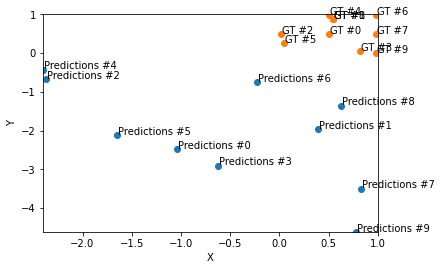

In [55]:
# Evaluate both images.
net_outputs = model(net_inputs)

# Plot for comparison.
gu.plot_gaze([net_outputs, labels], ['Predictions', 'GT'])

This is done by a short training of the pre-trained model using the new dataset. Training the entire model on our small dataset would quickly degrade generalization capability of the pre-trained model as it would forget the appearance variation from the large original dataset and only focus on visual features on our small samples. In another words, we would be where we started when training only on our data.

To avoid this, we keep the convolutional layers fixed and only train the top-most linear layer.

In [56]:
# The last layer we will optimize.
print(model.fc[-1])
# We only provide the last layer parameters to the optimizer.
optim = torch.optim.Adam(lr=1e-2, params=model.fc[-1].parameters())

Linear(in_features=128, out_features=2, bias=True)


Epoch 0: Loss = 5.128
Epoch 10: Loss = 0.900
Epoch 20: Loss = 0.323
Epoch 30: Loss = 0.149
Epoch 40: Loss = 0.050
Epoch 50: Loss = 0.028
Epoch 60: Loss = 0.016
Epoch 70: Loss = 0.011
Epoch 80: Loss = 0.009
Epoch 90: Loss = 0.008


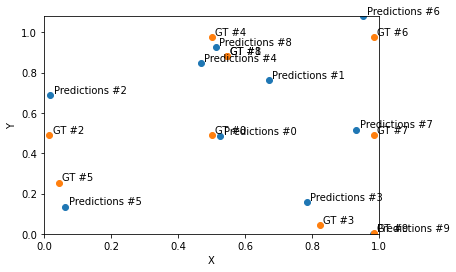

In [57]:
# Repeat 50 times.
for epoch in range(100):
    # Iterate over data here.
    for net_inputs, labels in train_dl:
        # Execute the model.
        net_outputs = model(net_inputs)

        # Compute loss.
        loss = criterion(net_outputs, labels)

        # Update the model parameters.
        optim.zero_grad()
        loss.backward()
        optim.step()

    if (epoch % 10 == 0):
        print(f'Epoch {epoch}: Loss = {loss.item():.3f}')

gu.plot_gaze([net_outputs, labels], ['Predictions', 'GT'])

Now we can repeat the mirror experiments and hopefully, the results should be better.

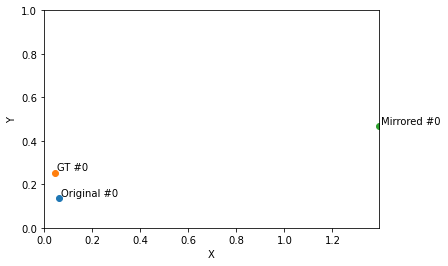

In [58]:
# Evaluate both images.
net_output = model(net_input)
net_output_mirrored = model(net_input_mirrored)

# Plot for comparison.
gu.plot_gaze([net_output, gaze_label, net_output_mirrored], ['Original', 'GT', 'Mirrored'])

Now you can go back to the top and try adding more training images to the dataset. The more training images the better the performance should get. However, at some point it is better to make the next step and store the training data on drive to prevent their loss.

However, we will not cover that in this tutorial. Instead, in the last cell you can test a code that will capture a frame from camera, crop a face image, pass it into the model and visualize the prediction.

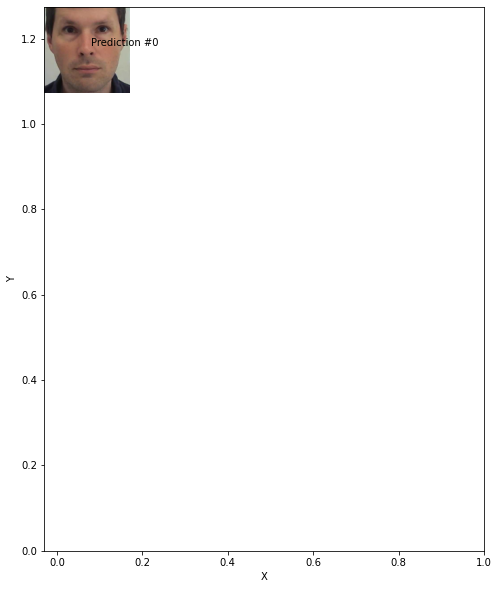

In [30]:
# 1. Capture and image from camera.
frame = capture_frame()

# 2. Detect the face.
face_rect = detect_face(frame)

# 3. Crop the face with 1.2x margin.
im_crop = crop_image(frame, face_rect, 1.2)

# 4. To torch tensor with 127x127 resolution.
im_tensor = numpy_image_to_tensor(im_crop, [127, 127])

# 5. Exectute the predictor model.
gaze = model(im_tensor.unsqueeze(0))

# 6. Plot gaze
gu.plot_gaze([gaze], ['Prediction'], [im_tensor[None]], figsize=[16,10])

THE END